In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt # viz
from scipy import stats
import json
from typing import List, Tuple

from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn import metrics, linear_model

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

In [7]:

# only test dataset includes evil samples.
train_df = pd.read_csv('./beth-dataset/labelled_training_data.csv')
test_df = train_df

# validation_df = pd.read_csv('./beth-dataset/labelled_validation_data.csv')

# use 10% of training data and test data for subset testing
# train_df = train_df.sample(frac=0.1)
# test_df = test_df.sample(frac=0.1)
# test_df = pd.read_csv('./beth-dataset/labelled_testing_data.csv')
# count number of unique observations in columns
print(test_df.nunique())

timestamp          762911
processId             545
threadId              588
parentProcessId       205
userId                  7
mountNamespace          6
processName            36
hostName                8
eventId                32
eventName              32
stackAddresses      97050
argsNum                 6
returnValue           524
args               214720
sus                     2
evil                    1
dtype: int64


In [8]:
# remove target columns sus and evil
y = test_df[['evil']]
X = test_df.drop(['sus', 'evil'], axis=1)
X = X[['mountNamespace']]
X = pd.get_dummies(X)


# traintest split on x and y
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

# make sure X_test and X_train have the same columns
X_test = X_test[X_train.columns]

In [9]:
# X_train.describe(include=['object', 'float', 'int'])
y_test.describe(), test_df.tail()

# # count number of evil
# print(y_train.value_counts())

(           evil
 count  228944.0
 mean        0.0
 std         0.0
 min         0.0
 25%         0.0
 50%         0.0
 75%         0.0
 max         0.0,
          timestamp  processId  threadId  parentProcessId  userId  \
 763139  324.542553       7274      7274             7108       0   
 763140  324.542579       7274      7274             7108       0   
 763141  324.543178       7274      7274             7108       0   
 763142  324.543695       7275      7275                1     109   
 763143  324.543831       7108      7108                1       0   
 
         mountNamespace processName        hostName  eventId  \
 763139      4026531840        sshd  ip-10-100-1-79     1003   
 763140      4026531840        sshd  ip-10-100-1-79       62   
 763141      4026531840        sshd  ip-10-100-1-79     1010   
 763142      4026531840        sshd  ip-10-100-1-79     1010   
 763143      4026531840        sshd  ip-10-100-1-79        3   
 
                  eventName     stackAddress

In [10]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import hamming_loss, f1_score

# Create the RandomForestClassifier
forest = RandomForestClassifier(max_features='log2', n_estimators=100, random_state=13, n_jobs=8)

# Use MultiOutputClassifier to handle multi-label classification
# multi_target_forest = MultiOutputClassifier(forest, n_jobs=8)

# Fit the model
forest.fit(X_train, y_train)

# Predict on the test set
y_pred = forest.predict(X_test)

# Use the classification report as before
print(classification_report(y_test, y_pred))

# Compute Hamming loss
print("Hamming Loss:", hamming_loss(y_test, y_pred))

# Compute F1 Score
# Micro averages in multi-label classification aggregates the contributions of all classes to compute the average metric
print("F1 Score (Micro):", f1_score(y_test, y_pred, average='macro'))

# crossvalidation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(forest, X, y, cv=10, scoring='f1_macro').mean()
print(scores)



              precision    recall  f1-score   support

           0       1.00      1.00      1.00    228944

    accuracy                           1.00    228944
   macro avg       1.00      1.00      1.00    228944
weighted avg       1.00      1.00      1.00    228944

Hamming Loss: 0.0
F1 Score (Micro): 1.0
1.0


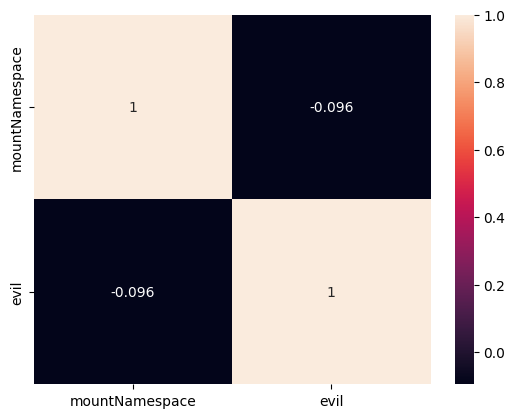

In [ ]:
# plot orrelaton matrix for test_df
test_df = pd.concat([X_test, y_test], axis=1)
corr = test_df.corr()
sns.heatmap(corr, annot=True)
plt.show()


In [ ]:
# initiate transformer model from torch
